# Ładowanie bibliotek

In [113]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import folium

from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.functions import trim
from pyspark.sql.types import FloatType
from pyspark.sql.functions import udf, row_number
from pyspark.sql.window import Window

warnings.filterwarnings("ignore")
spark = SparkSession.builder.getOrCreate()

# Zadanie 1

In [114]:
country_path = "countries of the world.csv"
df_countries = spark.read.csv(country_path, inferSchema = True,header = True)
df_countries.printSchema()

root
 |-- Country: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- Population: integer (nullable = true)
 |-- Area (square miles): integer (nullable = true)
 |-- Pop. Density (per sq. mi.): string (nullable = true)
 |-- Coastline (coast/area ratio): string (nullable = true)
 |-- Net migration: string (nullable = true)
 |-- Infant mortality (per 1000 births): string (nullable = true)
 |-- GDP ($ per capita): integer (nullable = true)
 |-- Literacy (%): string (nullable = true)
 |-- Phones (per 1000): string (nullable = true)
 |-- Arable (%): string (nullable = true)
 |-- Crops (%): string (nullable = true)
 |-- Other (%): string (nullable = true)
 |-- Climate: string (nullable = true)
 |-- Birthrate: string (nullable = true)
 |-- Deathrate: string (nullable = true)
 |-- Agriculture: string (nullable = true)
 |-- Industry: string (nullable = true)
 |-- Service: string (nullable = true)



In [115]:
df_countries.toPandas()

Country                               Region  Population  \
0       Afghanistan         ASIA (EX. NEAR EAST)             31056997   
1           Albania   EASTERN EUROPE                          3581655   
2           Algeria   NORTHERN AFRICA                        32930091   
3    American Samoa   OCEANIA                                   57794   
4           Andorra   WESTERN EUROPE                            71201   
..               ...                                  ...         ...   
222       West Bank   NEAR EAST                               2460492   
223  Western Sahara   NORTHERN AFRICA                          273008   
224           Yemen   NEAR EAST                              21456188   
225          Zambia   SUB-SAHARAN AFRICA                     11502010   
226        Zimbabwe   SUB-SAHARAN AFRICA                     12236805   

     Area (square miles) Pop. Density (per sq. mi.)  \
0                 647500                       48,0   
1                  28748                      124,6   
2                2381740                       13,8   
3                    199                      290,4   
4                    468                      152,1   
..                   ...                        ...   
222                 5860                      419,9   
223               266000                        1,0   
224               527970                       40,6   
225               752614                       15,3   
226               390580                       31,3   

    Coastline (coast/area ratio) Net migration  \
0                           0,00         23,06   
1                           1,26         -4,93   
2                           0,04         -0,39   
3                          58,29        -20,71   
4                           0,00           6,6   
..                           ...           ...   
222                         0,00          2,98   
223                         0,42          None   
224                         0,36             0   
225                         0,00             0   
226                         0,00             0   

    Infant mortality (per 1000 births)  GDP ($ per capita) Literacy (%)  \
0                               163,07               700.0         36,0   
1                                21,52              4500.0         86,5   
2                                   31              6000.0         70,0   
3                                 9,27              8000.0         97,0   
4                                 4,05             19000.0        100,0   
..                                 ...                 ...          ...   
222                              19,62               800.0         None   
223                               None                 NaN         None   
224                               61,5               800.0         50,2   
225                              88,29               800.0         80,6   
226                              67,69              1900.0         90,7   

    Phones (per 1000) Arable (%) Crops (%) Other (%) Climate Birthrate  \
0                 3,2      12,13      0,22     87,65       1      46,6   
1                71,2      21,09      4,42     74,49       3     15,11   
2                78,1       3,22      0,25     96,53       1     17,14   
3               259,5         10        15        75       2     22,46   
4               497,2       2,22         0     97,78       3      8,71   
..                ...        ...       ...       ...     ...       ...   
222             145,2       16,9     18,97     64,13       3     31,67   
223              None       0,02         0     99,98       1      None   
224              37,2       2,78      0,24     96,98       1     42,89   
225               8,2       7,08      0,03      92,9       2        41   
226              26,8       8,32      0,34     91,34       2     28,01   

    Deathrate Agriculture Industry Service  
0       20,34        0,38     0,24    0

In [116]:
# data processing
countries_poor = df_countries.select('GDP ($ per capita)','Birthrate','Deathrate').filter(col('GDP ($ per capita)').isNotNull()).orderBy('GDP ($ per capita)').limit(30).toPandas()
countries_poor['Birthrate'] = pd.to_numeric(countries_poor['Birthrate'].str.replace(',','.'))
countries_poor['Deathrate'] = pd.to_numeric(countries_poor['Deathrate'].str.replace(',','.'))
countries_poor.head(5)

GDP ($ per capita)  Birthrate  Deathrate
0                 500      26.99       6.24
1                 500      45.76      23.03
2                 500      45.13      16.63
3                 600      42.22      13.46
4                 600      39.45       3.80

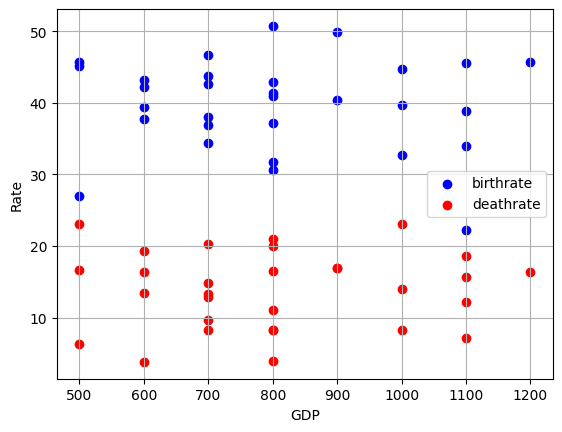

In [117]:
fig, ax = plt.subplots()

ax.scatter(countries_poor['GDP ($ per capita)'],countries_poor['Birthrate'],color='blue',label='birthrate')
ax.scatter(countries_poor['GDP ($ per capita)'],countries_poor['Deathrate'],color='red',label='deathrate')
ax.set_xlabel('GDP')
ax.set_ylabel('Rate')
ax.legend()
plt.grid(True)
plt.show()

In [118]:
countries_poor_binned = countries_poor.groupby('GDP ($ per capita)').agg({'Birthrate' : [np.mean, np.std], 'Deathrate': [np.mean,np.std]})
countries_poor_binned = countries_poor_binned.fillna(0)

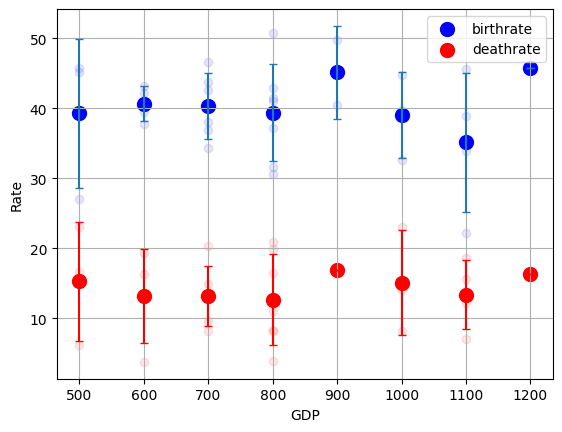

In [119]:
fig, ax = plt.subplots()

ax.scatter(
    countries_poor['GDP ($ per capita)'],
    countries_poor['Birthrate'],
    color='blue',
    alpha=0.1)

ax.scatter(
    countries_poor_binned.index.values,
    countries_poor_binned[('Birthrate','mean')],
    color='blue',
    label='birthrate',
    s=100)

ax.errorbar(
    countries_poor_binned.index.values,
    countries_poor_binned[('Birthrate','mean')],
    yerr=countries_poor_binned[('Birthrate','std')],
    fmt='none',
    capsize=3
)
ax.scatter(
    countries_poor['GDP ($ per capita)'],
    countries_poor['Deathrate'],
    color='red',
    alpha=0.1)

ax.scatter(
    countries_poor_binned.index.values,
    countries_poor_binned[('Deathrate','mean')],
    color='red',
    label='deathrate',
    s=100)

ax.errorbar(
    countries_poor_binned.index.values,
    countries_poor_binned[('Deathrate','mean')],
    yerr=countries_poor_binned[('Deathrate','std')],
    fmt='none',
    capsize=3,
    ecolor='r'
)

ax.set_xlabel('GDP')
ax.set_ylabel('Rate')
ax.legend()
plt.grid(True)
plt.show()

In [120]:
countries_rich = df_countries.select('GDP ($ per capita)','Birthrate','Deathrate').filter(col('GDP ($ per capita)').isNotNull()).orderBy(col('GDP ($ per capita)').desc()).limit(30).toPandas()
countries_rich['Birthrate'] = pd.to_numeric(countries_rich['Birthrate'].str.replace(',','.'))
countries_rich['Deathrate'] = pd.to_numeric(countries_rich['Deathrate'].str.replace(',','.'))

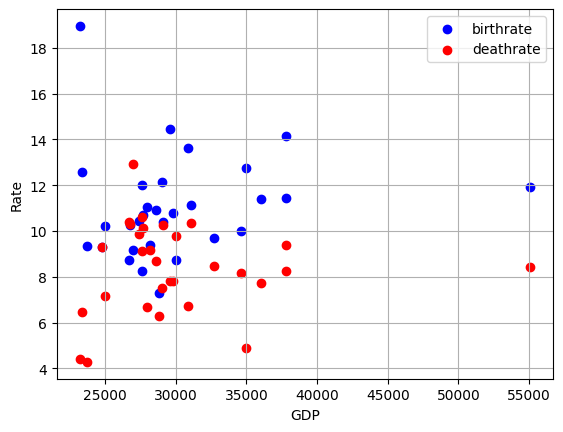

In [121]:
fig, ax = plt.subplots()

ax.scatter(countries_rich['GDP ($ per capita)'],countries_rich['Birthrate'],color='blue',label='birthrate')
ax.scatter(countries_rich['GDP ($ per capita)'],countries_rich['Deathrate'],color='red',label='deathrate')
ax.set_xlabel('GDP')
ax.set_ylabel('Rate')
ax.legend()
plt.grid(True)
plt.show()

In [122]:
bins = np.arange(countries_rich['GDP ($ per capita)'].min(),countries_rich['GDP ($ per capita)'].max()+2000,2000)
points, births_mean, births_std, deaths_mean, deaths_std = [], [], [], [], []
for i in range(1,len(bins)):
    index = (countries_rich['GDP ($ per capita)'] >= bins[i-1]) & (countries_rich['GDP ($ per capita)'] < bins[i])
    births = countries_rich.loc[index,'Birthrate']
    deaths = countries_rich.loc[index,'Deathrate']
    if len(births) > 0:
        points.append(bins[i-1]+1000)
        births_mean.append(births.mean())
        births_std.append(births.std())
        deaths_mean.append(deaths.mean())
        deaths_std.append(deaths.std())

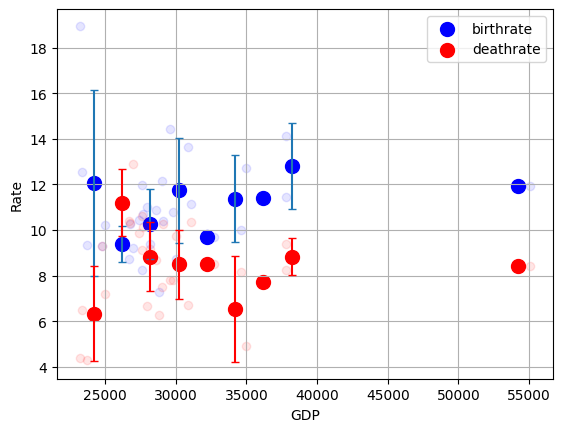

In [123]:
fig, ax = plt.subplots()

ax.scatter(
    countries_rich['GDP ($ per capita)'],
    countries_rich['Birthrate'],
    color='blue',
    alpha=0.1)

ax.scatter(
    points,
    births_mean,
    color='blue',
    label='birthrate',
    s=100)

ax.errorbar(
    points,
    births_mean,
    yerr=births_std,
    fmt='none',
    capsize=3
)
ax.scatter(
    countries_rich['GDP ($ per capita)'],
    countries_rich['Deathrate'],
    color='red',
    alpha=0.1)

ax.scatter(
    points,
    deaths_mean,
    color='red',
    label='deathrate',
    s=100)

ax.errorbar(
    points,
    deaths_mean,
    yerr=deaths_std,
    fmt='none',
    capsize=3,
    ecolor='r'
)

ax.set_xlabel('GDP')
ax.set_ylabel('Rate')
ax.legend()
plt.grid(True)
plt.show()

# Zadanie 2

In [124]:
airports_path = "airports.csv"

In [125]:
airports = spark.read.csv(airports_path, inferSchema = True)

In [126]:
airports.toPandas()

_c0                                          _c1           _c2  \
0         1                               Goroka Airport        Goroka   
1         2                               Madang Airport        Madang   
2         3                 Mount Hagen Kagamuga Airport   Mount Hagen   
3         4                               Nadzab Airport        Nadzab   
4         5  Port Moresby Jacksons International Airport  Port Moresby   
...     ...                                          ...           ...   
7179  12053                               Rugao Air Base         Rugao   
7180  12054                                Wuhu Air Base          Wuhu   
7181  12055                             Shanshan Airport      Shanshan   
7182  12056                        Yingkou Lanqi Airport       Yingkou   
7183  12057                      Shenyang Dongta Airport      Shenyang   

                   _c3  _c4   _c5        _c6         _c7   _c8 _c9 _c10  \
0     Papua New Guinea  GKA  AYGA  -6.081690  145.391998  5282  10    U   
1     Papua New Guinea  MAG  AYMD  -5.207080  145.789001    20  10    U   
2     Papua New Guinea  HGU  AYMH  -5.826790  144.296005  5388  10    U   
3     Papua New Guinea  LAE  AYNZ  -6.569803  146.725977   239  10    U   
4     Papua New Guinea  POM  AYPY  -9.443380  147.220001   146  10    U   
...                ...  ...   ...        ...         ...   ...  ..  ...   
7179             China  RUG  ZSRG  32.257885  120.501656     0  \N   \N   
7180             China  WHU  ZSWU  31.390600  118.408997     0  \N   \N   
7181             China  SXJ  ZWSS  42.911701   90.247498     0  \N   \N   
7182             China  YKH  ZYYK  40.542524  122.358600     0  \N   \N   
7183             China   \N  ZYYY  41.784401  123.496002     0  \N   \N   

                      _c11     _c12         _c13  
0     Pacific/Port_Moresby  airport  OurAirports  
1     Pacific/Port_Moresby  airport  OurAirports  
2     Pacific/Port_Moresby  airport  OurAirports  
3     Pacific/Port_Moresby  airport  OurAirports  
4     Pacific/Port_Moresby  airport  OurAirports  
...                    ...      ...          ...  
7179                    \N  airport  OurAirports  
7180                    \N  airport  OurAirports  
7181                    \N  airport  OurAirports  
7182                    \N  airport  OurAirports  
7183                    \N  airport  OurAirports  

[7184 rows x 14 columns]

In [127]:
airports = airports.toDF('Airport ID','Name','City','Country','IATA','ICAO','Latitude','Longitude','Altitude','Timezone','DST','Tz','Type','Source')
airports = airports.withColumn('Country',trim(col('Country')))
airports.toPandas()

Airport ID                                         Name          City  \
0              1                               Goroka Airport        Goroka   
1              2                               Madang Airport        Madang   
2              3                 Mount Hagen Kagamuga Airport   Mount Hagen   
3              4                               Nadzab Airport        Nadzab   
4              5  Port Moresby Jacksons International Airport  Port Moresby   
...          ...                                          ...           ...   
7179       12053                               Rugao Air Base         Rugao   
7180       12054                                Wuhu Air Base          Wuhu   
7181       12055                             Shanshan Airport      Shanshan   
7182       12056                        Yingkou Lanqi Airport       Yingkou   
7183       12057                      Shenyang Dongta Airport      Shenyang   

               Country IATA  ICAO   Latitude   Longitude  Altitude Timezone  \
0     Papua New Guinea  GKA  AYGA  -6.081690  145.391998      5282       10   
1     Papua New Guinea  MAG  AYMD  -5.207080  145.789001        20       10   
2     Papua New Guinea  HGU  AYMH  -5.826790  144.296005      5388       10   
3     Papua New Guinea  LAE  AYNZ  -6.569803  146.725977       239       10   
4     Papua New Guinea  POM  AYPY  -9.443380  147.220001       146       10   
...                ...  ...   ...        ...         ...       ...      ...   
7179             China  RUG  ZSRG  32.257885  120.501656         0       \N   
7180             China  WHU  ZSWU  31.390600  118.408997         0       \N   
7181             China  SXJ  ZWSS  42.911701   90.247498         0       \N   
7182             China  YKH  ZYYK  40.542524  122.358600         0       \N   
7183             China   \N  ZYYY  41.784401  123.496002         0       \N   

     DST                    Tz     Type       Source  
0      U  Pacific/Port_Moresby  airport  OurAirports  
1      U  Pacific/Port_Moresby  airport  OurAirports  
2      U  Pacific/Port_Moresby  airport  OurAirports  
3      U  Pacific/Port_Moresby  airport  OurAirports  
4      U  Pacific/Port_Moresby  airport  OurAirports  
...   ..                   ...      ...          ...  
7179  \N                    \N  airport  OurAirports  
7180  \N                    \N  airport  OurAirports  
7181  \N                    \N  airport  OurAirports  
7182  \N                    \N  airport  OurAirports  
7183  \N                    \N  airport  OurAirports  

[7184 rows x 14 columns]

In [128]:
airports_coordinates = airports.select('Name','Longitude','Latitude').na.drop().toPandas()

In [129]:
m = folium.Map()

for _, row in airports_coordinates.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=row['Name'],
    ).add_to(m)
   
m

# Zadanie 3

In [130]:
airports.printSchema()

root
 |-- Airport ID: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- IATA: string (nullable = true)
 |-- ICAO: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Altitude: integer (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- DST: string (nullable = true)
 |-- Tz: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Source: string (nullable = true)



In [131]:
def feet_to_meters(s) -> float:
    return s * 0.3048

In [132]:
float_udf = udf(feet_to_meters, FloatType())

In [133]:
airports_converted = airports.withColumn('Meters above sea level', float_udf('Altitude'))

In [134]:
windowsspec = Window.partitionBy('Country').orderBy(col('Meters above sea level').asc())
airports_ordered = airports_converted.select('Country','Meters above sea level','Longitude','Latitude','Name') \
.withColumn('rank',row_number().over(windowsspec))
airports_10_highest = airports_ordered.filter(col('rank') == 1).drop('rank').orderBy(col('Meters above sea level').desc()).limit(10)
airporst_highest_df = airports_10_highest.toPandas()

In [135]:
m = folium.Map()

for _, row in airporst_highest_df.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"{row['Name']}\n{row['Meters above sea level']} m.n.p.m",
    ).add_to(m)
    
m

# Zadanie 4

In [136]:
file_path = "countries of the world.csv"

countries = spark.read.csv(file_path, inferSchema = True, header = True)
countries = countries.withColumn('Country',trim(col('Country')))

In [137]:
countries.toPandas()

Country                               Region  Population  \
0       Afghanistan        ASIA (EX. NEAR EAST)             31056997   
1           Albania  EASTERN EUROPE                          3581655   
2           Algeria  NORTHERN AFRICA                        32930091   
3    American Samoa  OCEANIA                                   57794   
4           Andorra  WESTERN EUROPE                            71201   
..              ...                                  ...         ...   
222       West Bank  NEAR EAST                               2460492   
223  Western Sahara  NORTHERN AFRICA                          273008   
224           Yemen  NEAR EAST                              21456188   
225          Zambia  SUB-SAHARAN AFRICA                     11502010   
226        Zimbabwe  SUB-SAHARAN AFRICA                     12236805   

     Area (square miles) Pop. Density (per sq. mi.)  \
0                 647500                       48,0   
1                  28748                      124,6   
2                2381740                       13,8   
3                    199                      290,4   
4                    468                      152,1   
..                   ...                        ...   
222                 5860                      419,9   
223               266000                        1,0   
224               527970                       40,6   
225               752614                       15,3   
226               390580                       31,3   

    Coastline (coast/area ratio) Net migration  \
0                           0,00         23,06   
1                           1,26         -4,93   
2                           0,04         -0,39   
3                          58,29        -20,71   
4                           0,00           6,6   
..                           ...           ...   
222                         0,00          2,98   
223                         0,42          None   
224                         0,36             0   
225                         0,00             0   
226                         0,00             0   

    Infant mortality (per 1000 births)  GDP ($ per capita) Literacy (%)  \
0                               163,07               700.0         36,0   
1                                21,52              4500.0         86,5   
2                                   31              6000.0         70,0   
3                                 9,27              8000.0         97,0   
4                                 4,05             19000.0        100,0   
..                                 ...                 ...          ...   
222                              19,62               800.0         None   
223                               None                 NaN         None   
224                               61,5               800.0         50,2   
225                              88,29               800.0         80,6   
226                              67,69              1900.0         90,7   

    Phones (per 1000) Arable (%) Crops (%) Other (%) Climate Birthrate  \
0                 3,2      12,13      0,22     87,65       1      46,6   
1                71,2      21,09      4,42     74,49       3     15,11   
2                78,1       3,22      0,25     96,53       1     17,14   
3               259,5         10        15        75       2     22,46   
4               497,2       2,22         0     97,78       3      8,71   
..                ...        ...       ...       ...     ...       ...   
222             145,2       16,9     18,97     64,13       3     31,67   
223              None       0,02         0     99,98       1      None   
224              37,2       2,78      0,24     96,98       1     42,89   
225               8,2       7,08      0,03      92,9       2        41   
226              26,8       8,32      0,34     91,34       2     28,01   

    Deathrate Agriculture Industry Service  
0       20,34        0,38     0,24    0,38  
1    

In [138]:
merged_data = airports.select('Country','Airport ID').join(countries,'Country','inner').toPandas()
merged_data.head(5)

Country  Airport ID                               Region  \
0  Papua New Guinea           1  OCEANIA                               
1  Papua New Guinea           2  OCEANIA                               
2  Papua New Guinea           3  OCEANIA                               
3  Papua New Guinea           4  OCEANIA                               
4  Papua New Guinea           5  OCEANIA                               

   Population  Area (square miles) Pop. Density (per sq. mi.)  \
0     5670544               462840                       12,3   
1     5670544               462840                       12,3   
2     5670544               462840                       12,3   
3     5670544               462840                       12,3   
4     5670544               462840                       12,3   

  Coastline (coast/area ratio) Net migration  \
0                         1,11             0   
1                         1,11             0   
2                         1,11             0   
3                         1,11             0   
4                         1,11             0   

  Infant mortality (per 1000 births)  GDP ($ per capita)  ...  \
0                              51,45              2200.0  ...   
1                              51,45              2200.0  ...   
2                              51,45              2200.0  ...   
3                              51,45              2200.0  ...   
4                              51,45              2200.0  ...   

  Phones (per 1000) Arable (%) Crops (%) Other (%) Climate Birthrate  \
0              10,9       0,46      1,44      98,1       2     29,36   
1              10,9       0,46      1,44      98,1       2     29,36   
2              10,9       0,46      1,44      98,1       2     29,36   
3              10,9       0,46      1,44      98,1       2     29,36   
4              10,9       0,46      1,44      98,1       2     29,36   

  Deathrate Agriculture Industry Service  
0      7,25       0,353    0,381   0,266  
1      7,25       0,353    0,381   0,266  
2      7,25       0,353    0,381   0,266  
3      7,25       0,353    0,381   0,266  
4      7,25       0,353    0,381   0,266  

[5 rows x 21 columns]

In [139]:
airport_countries = airports.select('Country').withColumnRenamed('Country','Country_airport')
miss_countries = airport_countries.select('Country_airport') \
.join(countries.select('Country'),airport_countries.Country_airport == countries.Country,'outer') \
.where((col('Country_airport').isNull()) | (col('Country').isNull()))  \
.toPandas()
miss_countries.head(5)

Country_airport  Country
0            None  Andorra
1      Antarctica     None
2      Antarctica     None
3      Antarctica     None
4      Antarctica     None

In [140]:
merged_data = airports.select('Country','Airport ID').join(countries,'Country','inner')
airport_by_country = merged_data.select('Country','Airport ID').groupBy('Country').count()
airports_by_land_area = airport_by_country.join(countries.select('Country','Area (square miles)'), 'Country', 'inner')

<Axes: xlabel='Area (square miles)', ylabel='count'>

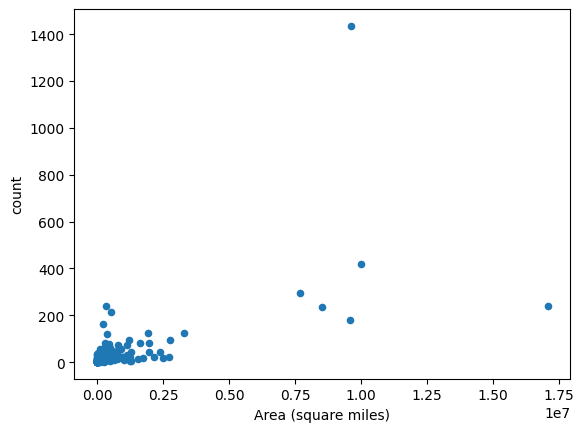

In [141]:
airports_by_land_area.toPandas().plot(x='Area (square miles)',y='count',kind='scatter')

<Axes: xlabel='Area (square miles)', ylabel='count'>

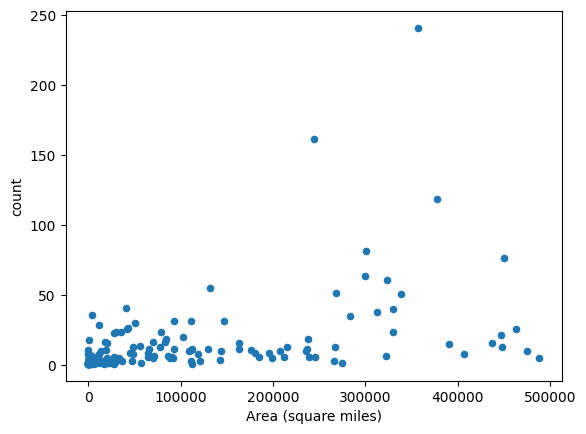

In [142]:
airports_by_land_area.filter(col('Area (square miles)') < 500000).toPandas().plot(x='Area (square miles)',y='count',kind='scatter')

# Zadanie 5

In [143]:
airport_by_region = merged_data.select('Region','Airport ID').groupBy('Region').count()

In [144]:
airport_by_region.toPandas()

Region  count
0   BALTICS                                 24
1                  C.W. OF IND. STATES     357
2         ASIA (EX. NEAR EAST)            1064
3   WESTERN EUROPE                        1224
4   NORTHERN AMERICA                      1875
5   NEAR EAST                              208
6   EASTERN EUROPE                         143
7   OCEANIA                                542
8   SUB-SAHARAN AFRICA                     534
9   NORTHERN AFRICA                        121
10              LATIN AMER. & CARIB        921

<Axes: ylabel='count'>

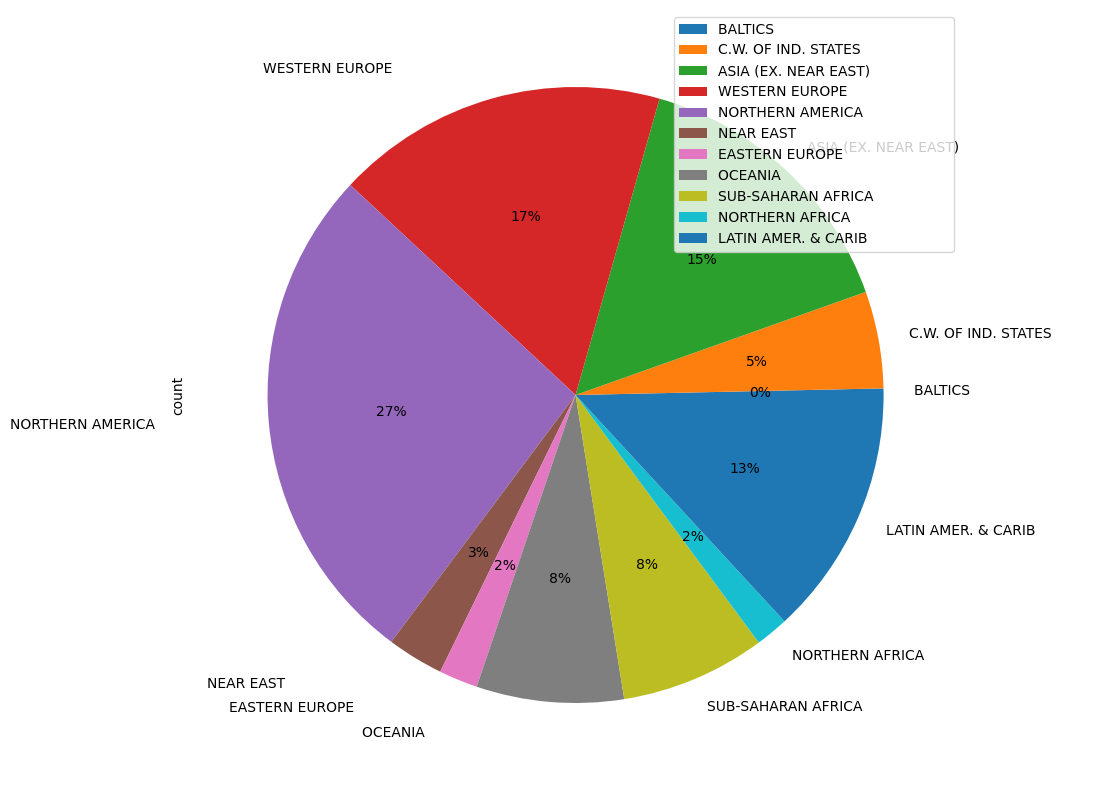

In [145]:
airport_by_region.toPandas().set_index('Region').plot(y='count',kind='pie',autopct='%1.0f%%',figsize=(10, 10))